In [1]:
## processing
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Initial try (based on run series 4-7)

### Building phase diagram by eye

In [2]:
df = pd.read_csv('../data/percolation-phases.csv')

In [3]:
df.head()

,series,run,length,percent_long,globally_contract
0,4,0,2,10,0
1,4,1,3,10,0
2,4,2,4,10,0
3,4,3,5,10,0
4,4,4,6,10,0


In [4]:
df_global = df[df.globally_contract == 1]
df_local = df[df.globally_contract == 0]

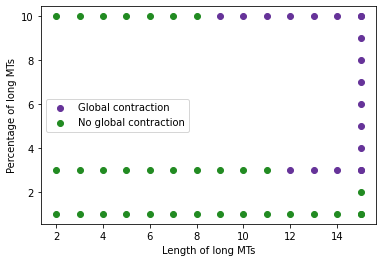

In [5]:
fig, ax = plt.subplots()
ax.scatter(df_global['length'], df_global['percent_long'], color='rebeccapurple')
ax.scatter(df_local['length'], df_local['percent_long'], color='forestgreen')
ax.set_xlabel('Length of long MTs')
ax.set_ylabel('Percentage of long MTs')
ax.legend(['Global contraction', 'No global contraction'])
plt.show()

#### Quantifying percentage microtubules in big aster

In [6]:
def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower


def in_circle(row, xc_2, yc_2, R_2):
    x_coord = row['posX']
    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1
        
def in_aster_fraction(row):
    series_index = int(row['series'])
    run_index = int(row['run'])
    if run_index < 10:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run000{}/fiber_position.txt'.format(series_index, run_index)
    elif run_index < 100:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run00{}/fiber_position.txt'.format(series_index, run_index)
    else:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run0{}/fiber_position.txt'.format(series_index, run_index)

    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    
    df_short = df[df.length == 1]
    df_long = df[df.length > 1]
    x_long, y_long = df_long['posX'].tolist(), df_long['posY'].tolist()

    def calc_R(xc, yc):
        return np.sqrt((x_long-xc)**2 + (y_long-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    center_2, ier = optimize.leastsq(f_2, (0, 0))
    xc_2, yc_2 = center_2
    R_2 = calc_R(*center_2).mean()

    col = df_short.apply(in_circle, args=(xc_2, yc_2, R_2), axis=1)
    df_short = df_short.assign(in_circle=col.values)

    #expected_fraction = math.pi * R_2**2 / (math.pi * 16.92**2)

    return sum(df_short['in_circle']) / len(df_short)

In [7]:
col = df.apply(in_aster_fraction, axis=1)
df = df.assign(in_aster_frac=col.values)

In [9]:
df = df.groupby(['length', 'percent_long']).mean().reset_index()

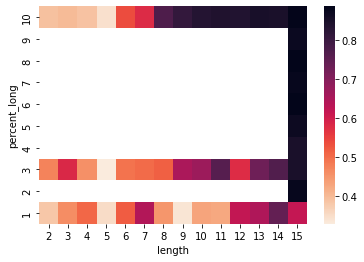

In [12]:
df_pivoted = df.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots()
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

## Building the full phase diagram

In [20]:
#df_list = []
#for file_number in range(175):
#    filename = '/Users/rosalindpan/thomsonlab/simulation/percolation/full-param-search4/config{}.cym'.format(
#                    (4-len(str(file_number)))*'0'+str(file_number))
#    file = open(filename, 'r')
#    lines = file.readlines()
#    num_long = int(lines[34].split()[1])
#    length = int(lines[36].strip().split()[2])
#    percent_long = round(num_long * length / 1000 * 100)
#    rv = {'series': 4, 'run': file_number, 'length': length, 'percent_long': percent_long, 'globally_contract':0}
#    df_list.append(rv)
#df = pd.DataFrame(df_list)

In [14]:
x_list = range(10, 41, 2)
l_list = range(5, 16, 1)

params = []
for x in x_list:
    for l in l_list:
        params.append((x, l))

df_list = []
for i in range(176):
    x, l = params[i]
    rv = {'series': 4, 'run': i, 'length': l, 'percent_long': x, 'globally_contract':0}
    df_list.append(rv)
df = pd.DataFrame(df_list)

In [16]:
col = df.apply(in_aster_fraction, axis=1)
df = df.assign(in_aster_frac=col.values)
df = df.groupby(['length', 'percent_long']).mean().reset_index()

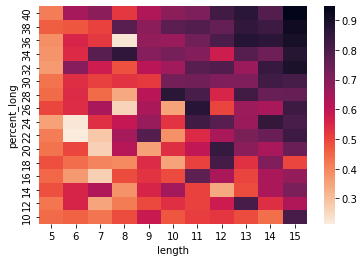

In [17]:
df_pivoted = df.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots()
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

## Alternative method of identifying asters

In [23]:
def aster_fraction(row):
    series_index = int(row['series'])
    run_index = int(row['run'])
    if run_index < 10:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run000{}/fiber_position.txt'.format(series_index, run_index)
    elif run_index < 100:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run00{}/fiber_position.txt'.format(series_index, run_index)
    else:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run0{}/fiber_position.txt'.format(series_index, run_index)

    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    df = df.dropna(how='any')

    x = df['posX']
    y = df['posY']
    data = np.vstack((x, y))

    kde = stats.kde.gaussian_kde(data)
    gx, gy = np.mgrid[x.min():x.max():128j, y.min():y.max():128j]
    gxy = np.dstack((gx, gy)) # shape is (128, 128, 2)
    z = np.apply_along_axis(kde, 2, gxy)
    z = z.reshape(128, 128)

    center_ix, center_iy = np.unravel_index(z.argmax(), z.shape)
    center_x = center_ix / 128 * (x.max() - x.min()) + x.min()
    center_y = center_iy / 128 * (y.max() - y.min()) + y.min()

    df_short = df[df.length == 1]
    col = df_short.apply(in_circle, args=(center_x, center_y, 1), axis=1)
    df_short = df_short.assign(in_circle=col.values)

    return sum(df_short['in_circle']) / len(df_short)

In [24]:
col = df.apply(aster_fraction, axis=1)
df = df.assign(in_aster_frac=col.values)
df = df.groupby(['length', 'percent_long']).mean().reset_index()

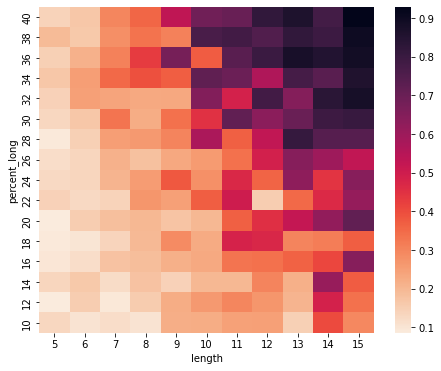

In [29]:
df_pivoted = df.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots(figsize=(7.5,6))
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()